# MobileNet & Vision Transformer (ViT) - EMNIST Classification

In [7]:
# Set working directory and Python path (Colab)
import os, sys

IN_COLAB = globals().get('IN_COLAB', False)
if IN_COLAB:
    os.chdir('/content/Alphabet-Classification-Description')
    proj_root = '/content/Alphabet-Classification-Description'
    if proj_root not in sys.path:
        sys.path.insert(0, proj_root)
    print(f"✅ Working directory: {os.getcwd()}")
    print("✅ Python path updated for utils imports")
else:
    # Local VS Code: ensure project root is on path
    parent_dir = os.path.abspath('..')
    if parent_dir not in sys.path:
        sys.path.insert(0, parent_dir)
    print(f"✅ Added {parent_dir} to Python path (local)")

✅ Added / to Python path (local)


In [8]:
%%bash
# Clone or update the repository (only in Colab)
if [ -d "/content/Alphabet-Classification-Description" ]; then
  echo "✅ Repository already exists"
  cd /content/Alphabet-Classification-Description
  git pull origin main
  echo "✅ Repository updated"
else
  echo "📥 Cloning repository..."
  git clone https://github.com/MORO-66t/Alphabet-Classification.git /content/Alphabet-Classification-Description
  cd /content/Alphabet-Classification-Description
  echo "✅ Repository cloned successfully!"
fi

✅ Repository already exists
Already up to date.
✅ Repository updated


From https://github.com/MORO-66t/Alphabet-Classification
 * branch            main       -> FETCH_HEAD


In [9]:
# Detect Colab environment
try:
    import google.colab  # type: ignore
    IN_COLAB = True
    print("✅ Running in Google Colab")
except Exception:
    IN_COLAB = False
    print("⚠️ Not in Colab - skipping Colab-specific setup")

✅ Running in Google Colab


# MobileNet

In [10]:
# Import utilities
import sys
import os

# Ensure path is set for both Colab and local
IN_COLAB = globals().get('IN_COLAB', False)
if IN_COLAB:
    proj_root = '/content/Alphabet-Classification-Description'
    if proj_root not in sys.path:
        sys.path.insert(0, proj_root)
    print("✅ Using Colab project root for imports")
else:
    parent_dir = os.path.abspath('..')
    if parent_dir not in sys.path:
        sys.path.insert(0, parent_dir)
    print(f"✅ Added {parent_dir} to Python path (local)")

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from utils.preprocessing import load_emnist_data, preprocess_emnist, preprocess_for_transfer_learning
from utils.evaluation import evaluate_model, generate_classification_report, analyze_overfitting, find_misclassified_examples
from utils.visualization import plot_training_history, plot_confusion_matrix, plot_roc_curves, plot_sample_predictions, plot_misclassified_examples

✅ Using Colab project root for imports


In [11]:
# Load and preprocess EMNIST dataset
train_data, test_data, label_map, num_classes = load_emnist_data()
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_emnist(train_data, test_data, num_classes)

# For transfer learning, resize to 32x32
X_train_resized, X_val_resized, X_test_resized = preprocess_for_transfer_learning(X_train, X_val, X_test, target_size=(32, 32))

Using Colab cache for faster access to the 'emnist' dataset.
Dataset path: /kaggle/input/emnist
Classes: 47
Train data shape: (112799, 785)
Test data shape: (18799, 785)
Original shapes:
  X_train: (112799, 784), y_train: (112799,)
  X_test: (18799, 784), y_test: (18799,)

After train/val split:
  Training set: (101519, 28, 28, 1), (101519,)
  Validation set: (11280, 28, 28, 1), (11280,)

Preprocessing complete! ✅
Resized to (32, 32) for transfer learning:
  X_train: (101519, 32, 32, 3)
  X_val: (11280, 32, 32, 3)
  X_test: (18799, 32, 32, 3)


In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, Input

In [13]:
# Build MobileNet Model

def build_mobilenet_model(input_shape=(32, 32, 3), num_classes=47):
    inputs = Input(shape=input_shape)
    
    # MobileNetV2 expects RGB input
    base_model = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    
    base_model.trainable = True
    
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs, name="MobileNet_EMNIST")
    return model

model_mobilenet = build_mobilenet_model()
model_mobilenet.summary()

/tmp/ipython-input-1410986843.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "MobileNet_EMNIST"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1, 1, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 47)             │        60,207 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,318,191 (8.84 MB)

 Trainable params: 2,284,079 (8.71 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [14]:
# Compile model
model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
# Callbacks
callbacks_mobilenet = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_accuracy'),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, monitor='val_loss')
]

In [16]:
# Train MobileNet
history_mobilenet = model_mobilenet.fit(
    X_train_resized, y_train,
    validation_data=(X_val_resized, y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks_mobilenet
)

Epoch 1/20
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 125s 46ms/step - accuracy: 0.3227 - loss: 2.7564 - val_accuracy: 0.2486 - val_loss: 2.8849 - learning_rate: 1.0000e-04
Epoch 2/20
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.7715 - loss: 0.7090 - val_accuracy: 0.6566 - val_loss: 1.3824 - learning_rate: 1.0000e-04
Epoch 3/20
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.8283 - loss: 0.5069 - val_accuracy: 0.8279 - val_loss: 0.5304 - learning_rate: 1.0000e-04
Epoch 4/20
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.8476 - loss: 0.4329 - val_accuracy: 0.8625 - val_loss: 0.3780 - learning_rate: 1.0000e-04
Epoch 5/20
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.8614 - loss: 0.3857 - val_accuracy: 0.8597 - val_loss: 0.3997 - learning_rate: 1.0000e-04
Epoch 6/20
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.8726 - loss: 0.3506 - val_accuracy: 0.8752 - val_loss: 0.3481 - learning_rate: 1.0000e-04
Epoch 7/20
1587/1587 ━━━━━━━━━━━━━━━━━━

In [17]:
# Evaluate MobileNet
test_loss, test_acc, y_pred, y_pred_proba, y_true = evaluate_model(model_mobilenet, X_test_resized, y_test)

588/588 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.8943 - loss: 0.3291

Test Loss: 0.3273
Test Accuracy: 0.8923



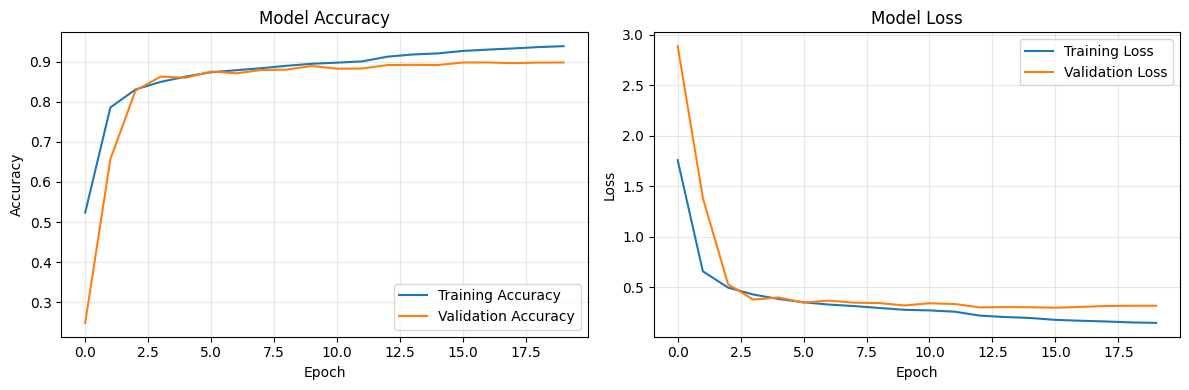

In [18]:
# Plot training history
plot_training_history(history_mobilenet)

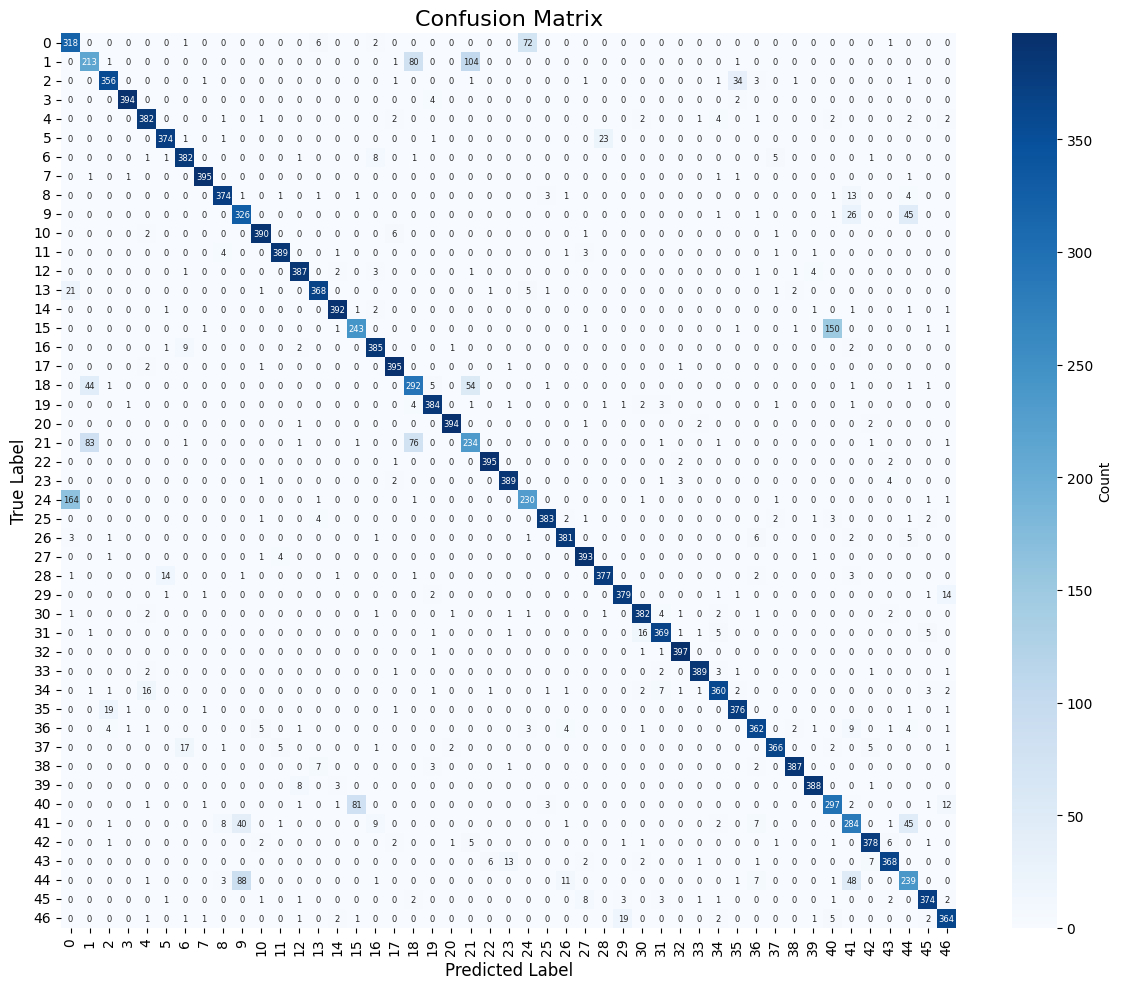

In [19]:
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, labels=label_map)

Total misclassified: 2025 out of 18799 (10.77%)
Total misclassified: 2025 out of 18799 (10.77%)


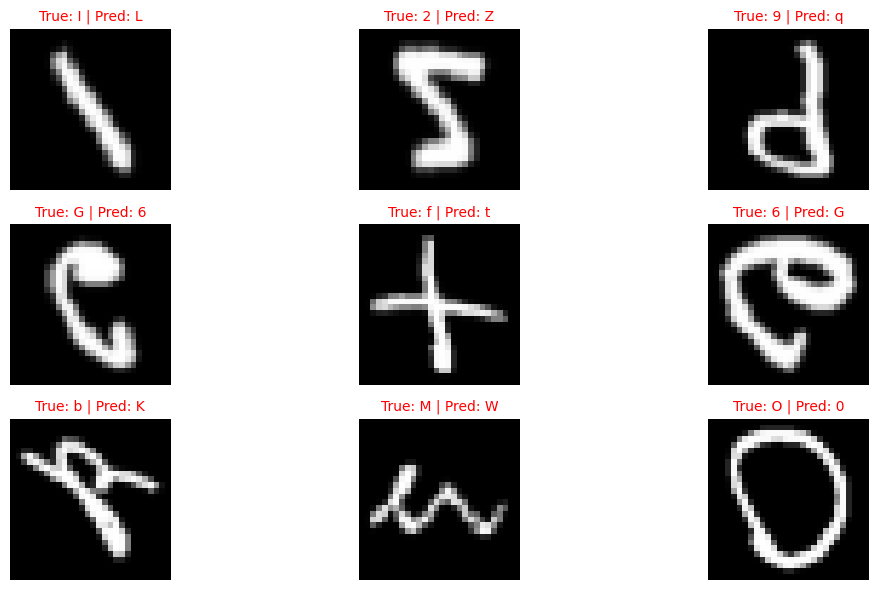

In [20]:
# Show misclassified examples
mis_idx = find_misclassified_examples(y_true, y_pred, X_test_resized)
plot_misclassified_examples(X_test, y_true, y_pred, label_map, mis_idx=mis_idx, n_samples=9)

In [21]:
# Data Augmentation for MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_mobilenet = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)

datagen_mobilenet.fit(X_train_resized)

In [ ]:
# Train with data augmentation
history_mobilenet_aug = model_mobilenet.fit(
    datagen_mobilenet.flow(X_train_resized, y_train, batch_size=64),
    validation_data=(X_val_resized, y_val),
    epochs=20,
    callbacks=callbacks_mobilenet
)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1587/1587 ━━━━━━━━━━━━━━━━━━━━ 124s 61ms/step - accuracy: 0.8639 - loss: 0.3884 - val_accuracy: 0.8940 - val_loss: 0.3048 - learning_rate: 6.2500e-06
Epoch 2/20
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 79s 50ms/step - accuracy: 0.8735 - loss: 0.3446 - val_accuracy: 0.8931 - val_loss: 0.3046 - learning_rate: 6.2500e-06
Epoch 3/20
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 76s 48ms/step - accuracy: 0.8782 - loss: 0.3323 - val_accuracy: 0.8927 - val_loss: 0.2998 - learning_rate: 6.2500e-06
Epoch 4/20
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 79s 50ms/step - accuracy: 0.8834 - loss: 0.3105 - val_accuracy: 0.8925 - val_loss: 0.3004 - learning_rate: 6.2500e-06
Epoch 5/20
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 77s 48ms/step - accuracy: 0.8856 - loss: 0.3065 - val_accuracy: 0.8932 - val_loss: 0.2972 - learning_rate: 6.2500e-06
Epoch 6/20
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 79s 50ms/step - accuracy: 0.8865 - loss: 0.3032 - val_accuracy: 0.8948 - val_loss: 0.2954 - learning_rate: 6.2500e-06
Epoch 7/20
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 78s 49ms

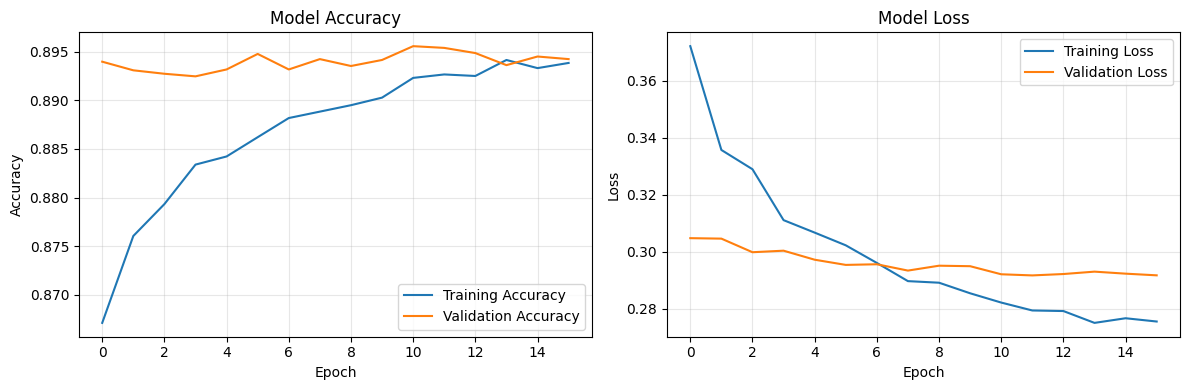

In [ ]:
# Plot training history after augmentation
plot_training_history(history_mobilenet_aug)

In [ ]:
# Analyze overfitting
overfitting_metrics = analyze_overfitting(history_mobilenet_aug)


Overfitting Analysis:
  Final Training Accuracy: 0.8938
  Final Validation Accuracy: 0.8942
  Overfitting Gap: -0.0004
  Final Training Loss: 0.2755
  Final Validation Loss: 0.2917
  Status: ✅ Excellent generalization (gap < 5%)



In [ ]:
# Save MobileNet model with proper directory creation
import os

save_dir = '../saved_models/mobilenet'
try:
    os.makedirs(save_dir, exist_ok=True)
    model_mobilenet.save(os.path.join(save_dir, 'final_emnist_mobilenet.keras'))
    print(f"✅ MobileNet model saved successfully to {os.path.abspath(save_dir)}")
except Exception as e:
    print(f"❌ Error saving MobileNet model: {e}")

✅ MobileNet model saved successfully!


588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8924 - loss: 0.3228

Test Loss: 0.3115
Test Accuracy: 0.8920

Classification Report:
              precision    recall  f1-score   support

           0     0.6065    0.8400    0.7044       400
           1     0.5505    0.6400    0.5919       400
           2     0.9318    0.8875    0.9091       400
           3     0.9950    0.9925    0.9937       400
           4     0.9564    0.9325    0.9443       400
           5     0.9328    0.9375    0.9352       400
           6     0.9496    0.9425    0.9460       400
           7     0.9875    0.9900    0.9888       400
           8     0.9603    0.9075    0.9332       400
           9     0.6756    0.8800    0.7644       400
           A     0.9583    0.9775    0.9678       400
           B     0.9585    0.9825    0.9704       400
           C     0.9691    0.9400    0.9543       400
           D     0.9244    0.9475    0.9358       400
           E     0.9799    0.9775    0.9787      

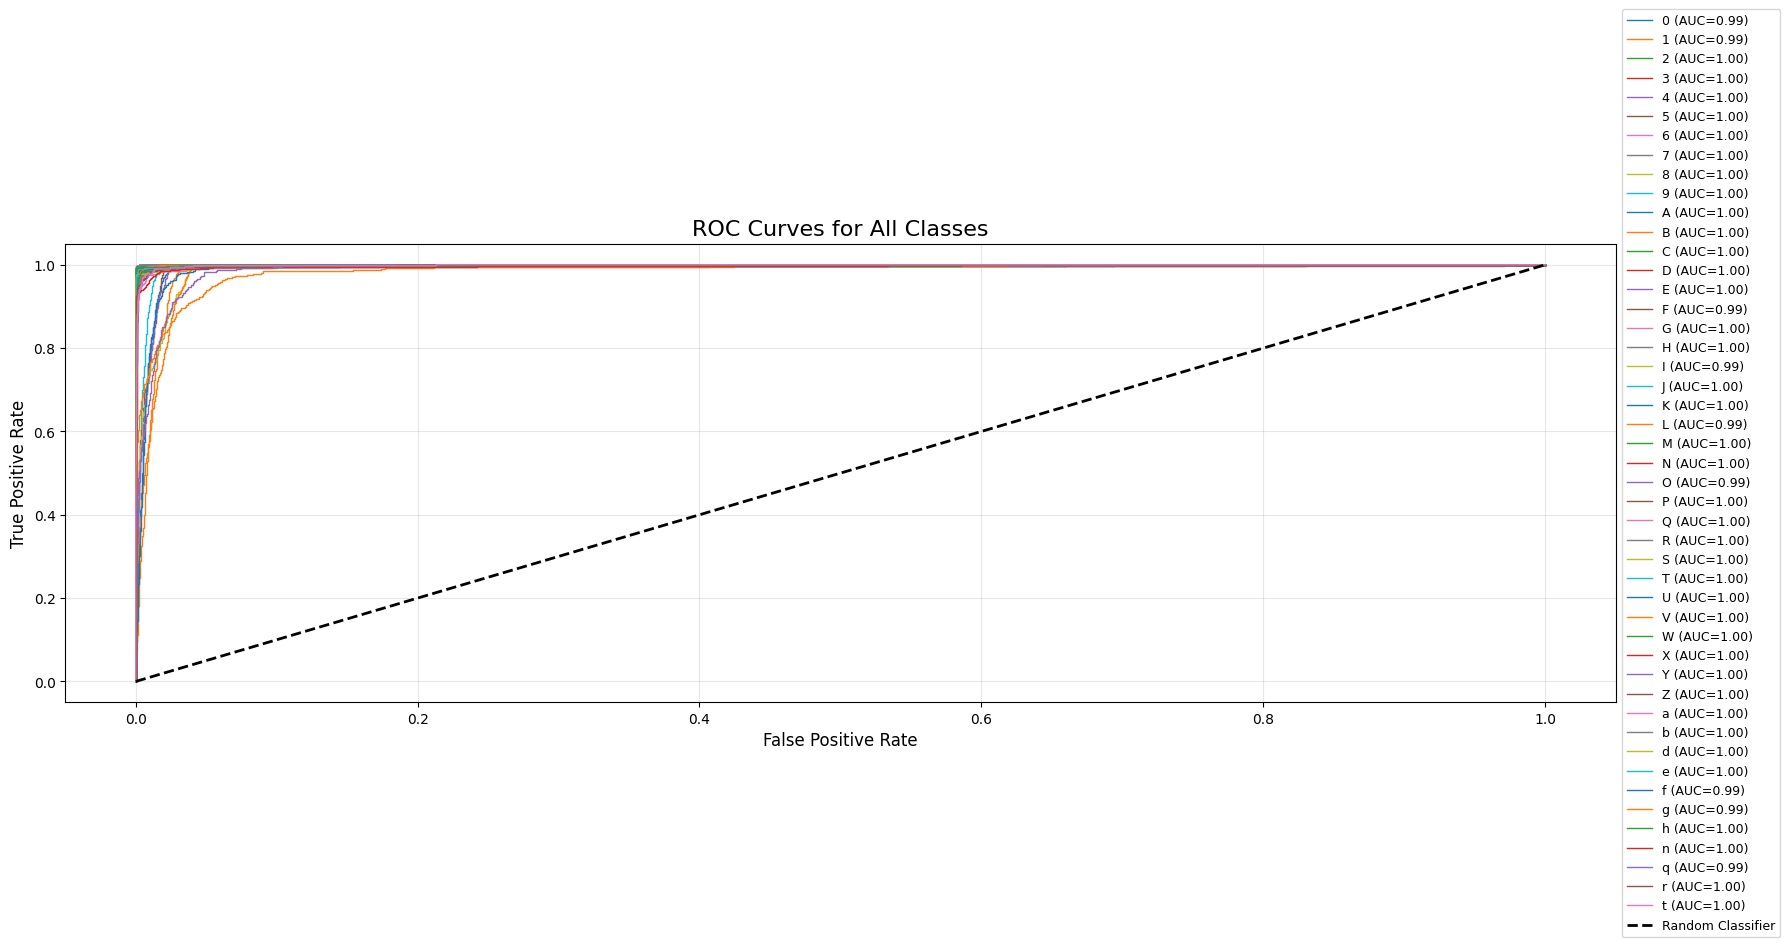

In [ ]:
# Final evaluation with classification report
test_loss, test_acc, y_pred, y_pred_proba, y_true = evaluate_model(model_mobilenet, X_test_resized, y_test)
generate_classification_report(y_true, y_pred, label_map)
plot_roc_curves(y_test, y_pred_proba, label_map, num_classes)

## VIT

In [ ]:
# Vision Transformer (ViT) for EMNIST (28x28x1 → 47 classes)
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import math

def create_vit_classifier(
    input_shape=(28, 28, 1),
    num_classes=47,
    image_size=28,
    patch_size=4,
    projection_dim=64,
    transformer_layers=4,
    num_heads=4,
    transformer_units=[128, 64],
    mlp_head_units=[256, 128],
    dropout_rate=0.1
):
    inputs = keras.Input(shape=input_shape)
    
    # 1) Patch embedding
    x = layers.Conv2D(
        filters=projection_dim,
        kernel_size=patch_size,
        strides=patch_size,
        padding="valid"
    )(inputs)
    
    # Flatten patches
    num_patches = (image_size // patch_size) ** 2
    x = layers.Reshape((num_patches, projection_dim))(x)
    
    # 2) Positional embeddings
    positions = tf.range(start=0, limit=num_patches, delta=1)
    pos_embedding_layer = layers.Embedding(
        input_dim=num_patches,
        output_dim=projection_dim
    )
    position_embeddings = pos_embedding_layer(positions)
    x = x + position_embeddings
    
    # 3) Transformer encoder blocks
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=projection_dim,
            dropout=dropout_rate
        )(x1, x1)
        
        x2 = layers.Add()([attention_output, x])
        
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        for units in transformer_units:
            x3 = layers.Dense(units, activation="gelu")(x3)
            x3 = layers.Dropout(dropout_rate)(x3)
        x = layers.Add()([x2, x3])
    
    # 4) Classification head
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    
    for units in mlp_head_units:
        x = layers.Dense(units, activation="gelu")(x)
        x = layers.Dropout(dropout_rate)(x)
    
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="vit_emnist")
    return model

# Create ViT model
model_vit = create_vit_classifier(input_shape=(28, 28, 1), num_classes=num_classes)

model_vit.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_vit.summary()

Model: "vit_emnist"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 7, 7, 64)  │      1,088 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 49, 64)    │          0 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 49, 64)    │          0 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 49, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 49, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 49, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 49, 128)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 49, 64)    │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 49, 64)    │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 49, 64)    │          0 │ add_1[0][0],      │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 49, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 64)    │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 49, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 49, 128)   │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 49, 64)    │      8,256 │ dropout_5[0][0] 

 Total params: 389,615 (1.49 MB)

 Trainable params: 389,615 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train ViT (with FIXED steps_per_epoch)
import math

# FIX: Correct steps_per_epoch calculation
batch_size = 64
steps_per_epoch = math.ceil(len(X_train) / batch_size)  # ✅ FIXED!

callbacks_vit = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
]

history_vit = model_vit.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,  # ✅ Now using correct value
    callbacks=callbacks_vit
)

Epoch 1/20
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 64s 24ms/step - accuracy: 0.2801 - loss: 2.5429 - val_accuracy: 0.6227 - val_loss: 1.1798 - learning_rate: 0.0010
Epoch 2/20
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 49s 12ms/step - accuracy: 0.6621 - loss: 1.0417 - val_accuracy: 0.7324 - val_loss: 0.8068 - learning_rate: 0.0010
Epoch 3/20
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7300 - loss: 0.8144 - val_accuracy: 0.7715 - val_loss: 0.6789 - learning_rate: 0.0010
Epoch 4/20
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7626 - loss: 0.7159 - val_accuracy: 0.7824 - val_loss: 0.6408 - learning_rate: 0.0010
Epoch 5/20
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.7773 - loss: 0.6547 - val_accuracy: 0.7989 - val_loss: 0.5808 - learning_rate: 0.0010
Epoch 6/20
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.7938 - loss: 0.6008 - val_accuracy: 0.8034 - val_loss: 0.5643 - learning_rate: 0.0010
Epoch 7/20
1587/1587 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accura

In [ ]:
# Save ViT model with proper directory creation
import os

save_dir = '../saved_models/vit'
try:
    os.makedirs(save_dir, exist_ok=True)
    model_vit.save(os.path.join(save_dir, 'final_emnist_vit.keras'))
    print(f"✅ ViT model saved successfully to {os.path.abspath(save_dir)}")
except Exception as e:
    print(f"❌ Error saving ViT model: {e}")

✅ ViT model saved successfully!


: 

: 

: 

In [ ]:
# Evaluate ViT
test_loss_vit, test_acc_vit, y_pred_vit, y_pred_proba_vit, y_true_vit = evaluate_model(model_vit, X_test, y_test)
generate_classification_report(y_true_vit, y_pred_vit, label_map)

588/588 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8590 - loss: 0.4178

Test Loss: 0.4139
Test Accuracy: 0.8608

Classification Report:
              precision    recall  f1-score   support

           0     0.6208    0.7000    0.6580       400
           1     0.5167    0.8100    0.6310       400
           2     0.8842    0.8975    0.8908       400
           3     0.9645    0.9500    0.9572       400
           4     0.9086    0.8950    0.9018       400
           5     0.9203    0.8375    0.8770       400
           6     0.8981    0.9250    0.9113       400
           7     0.9675    0.9675    0.9675       400
           8     0.9056    0.8875    0.8965       400
           9     0.6336    0.8775    0.7358       400
           A     0.9333    0.9450    0.9391       400
           B     0.9271    0.9225    0.9248       400
           C     0.9229    0.9275    0.9252       400
           D     0.9033    0.8875    0.8953       400
           E     0.9721    0.9575    0.9647      

'              precision    recall  f1-score   support\n\n           0     0.6208    0.7000    0.6580       400\n           1     0.5167    0.8100    0.6310       400\n           2     0.8842    0.8975    0.8908       400\n           3     0.9645    0.9500    0.9572       400\n           4     0.9086    0.8950    0.9018       400\n           5     0.9203    0.8375    0.8770       400\n           6     0.8981    0.9250    0.9113       400\n           7     0.9675    0.9675    0.9675       400\n           8     0.9056    0.8875    0.8965       400\n           9     0.6336    0.8775    0.7358       400\n           A     0.9333    0.9450    0.9391       400\n           B     0.9271    0.9225    0.9248       400\n           C     0.9229    0.9275    0.9252       400\n           D     0.9033    0.8875    0.8953       400\n           E     0.9721    0.9575    0.9647       400\n           F     0.6947    0.5575    0.6186       400\n           G     0.8908    0.9175    0.9039       400\n       

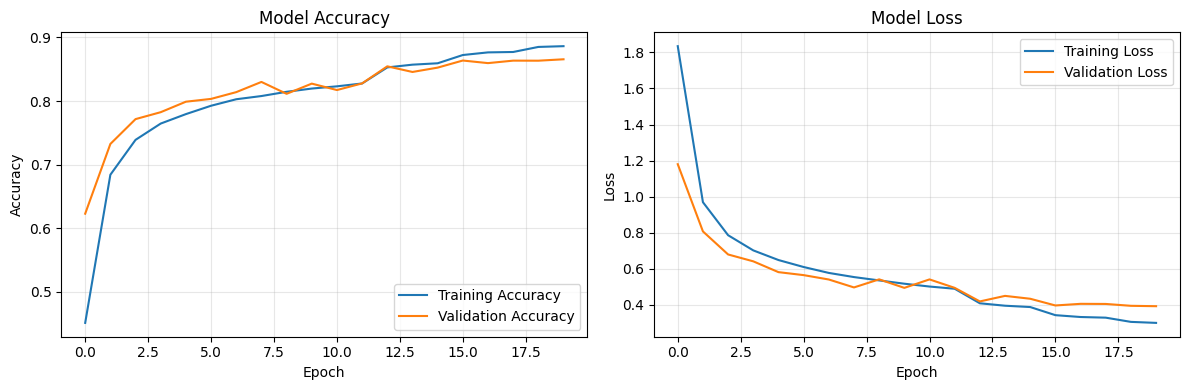

In [ ]:
# Plot ViT training history
plot_training_history(history_vit)

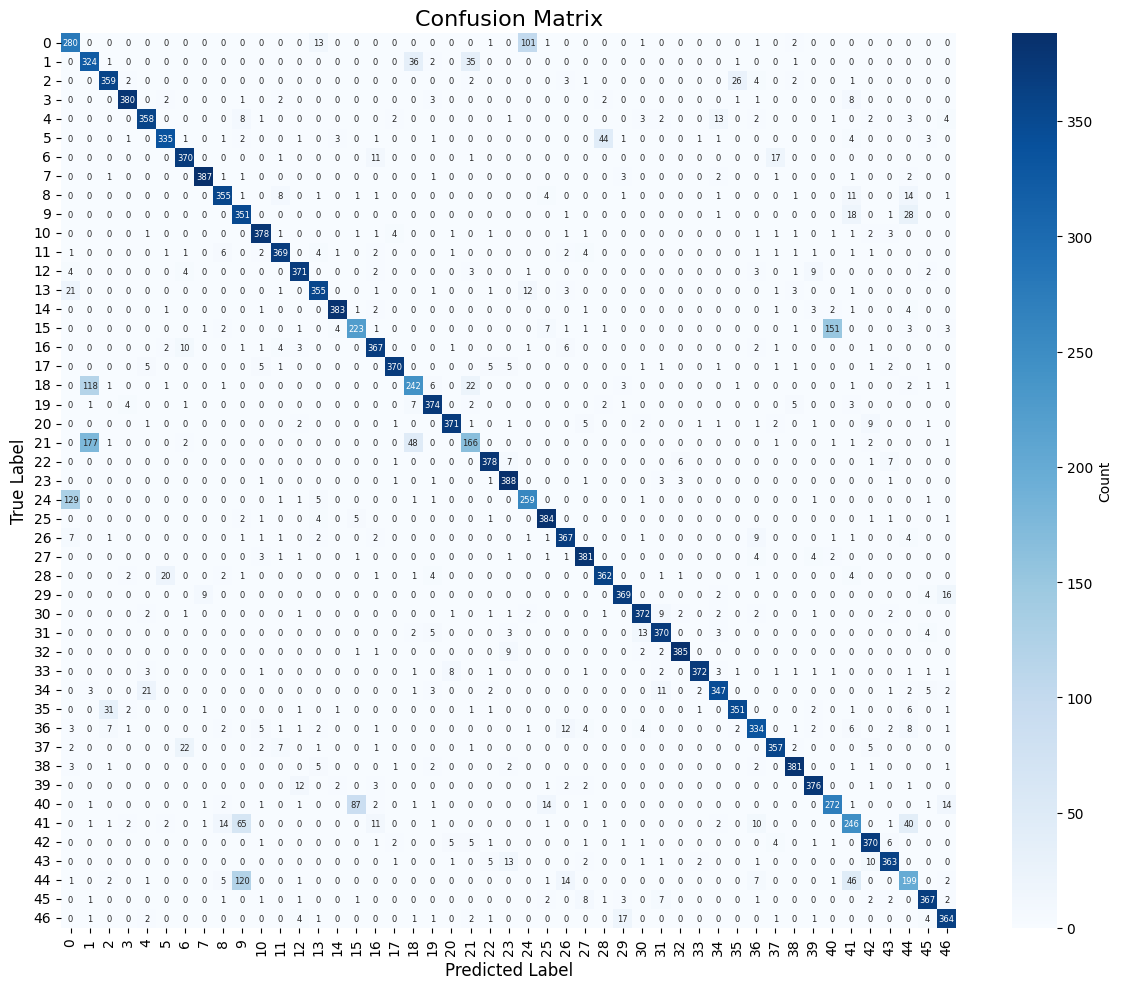

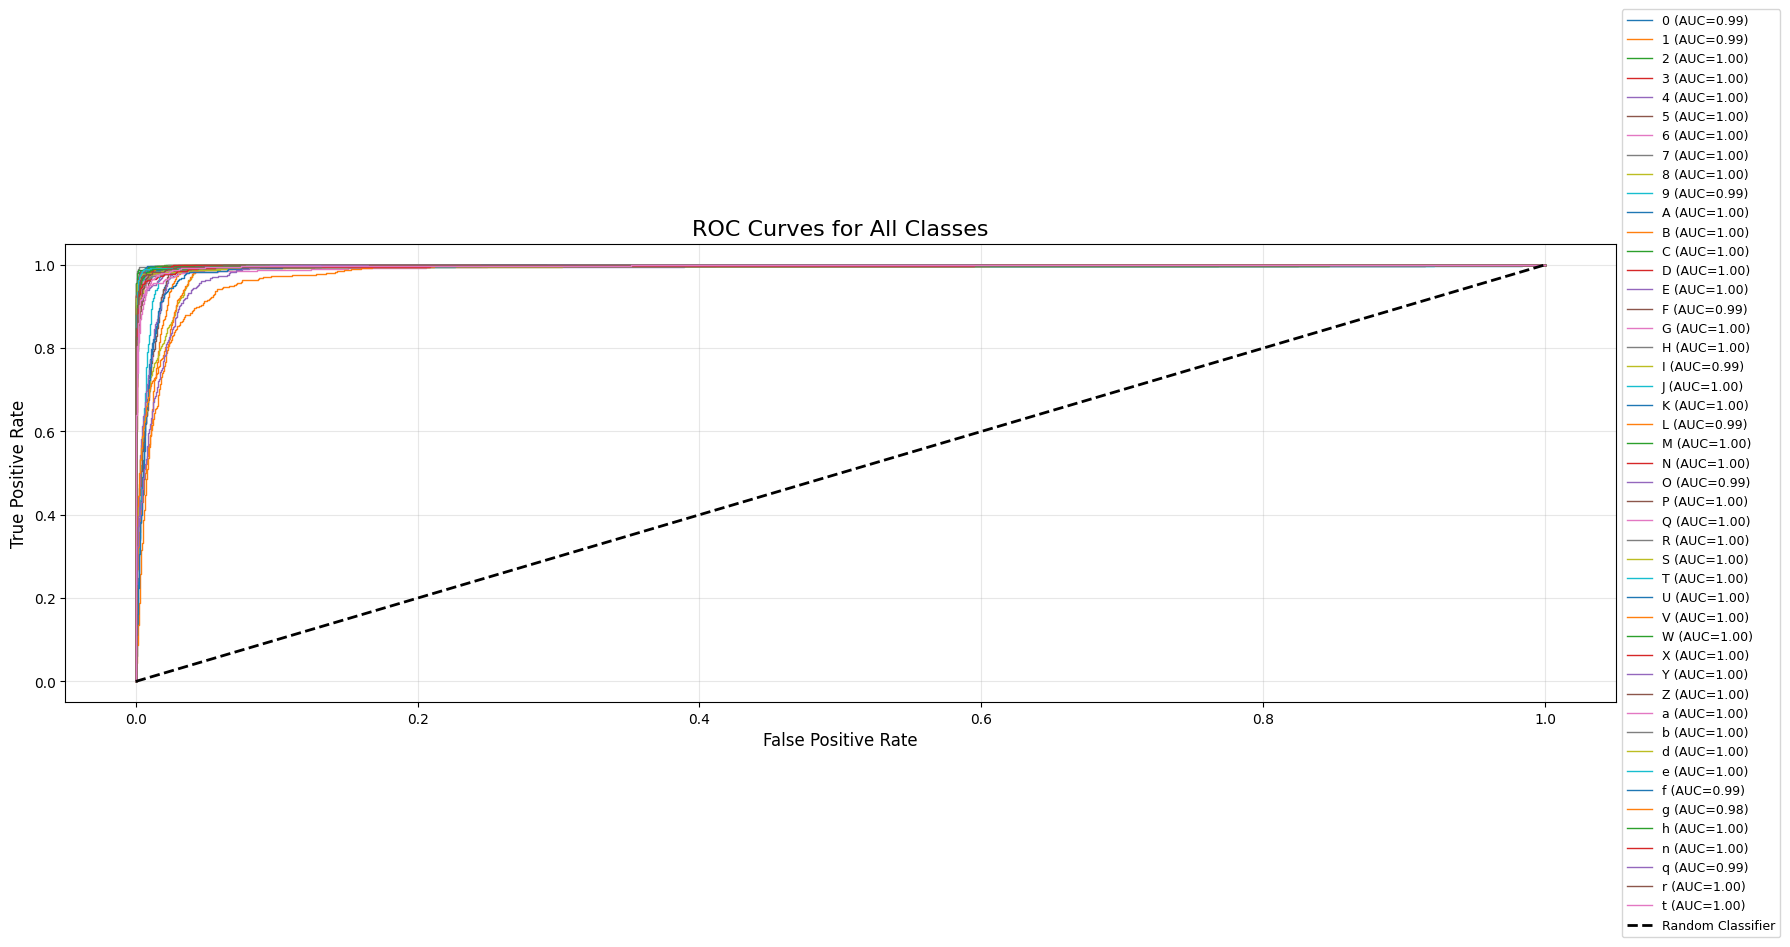

In [ ]:
# Plot ViT confusion matrix and ROC curves
plot_confusion_matrix(y_true_vit, y_pred_vit, labels=label_map)
plot_roc_curves(y_test, y_pred_proba_vit, label_map, num_classes)

In [ ]:
# Analyze ViT overfitting
analyze_overfitting(history_vit)


Overfitting Analysis:
  Final Training Accuracy: 0.8863
  Final Validation Accuracy: 0.8657
  Overfitting Gap: 0.0206
  Final Training Loss: 0.2993
  Final Validation Loss: 0.3919
  Status: ✅ Excellent generalization (gap < 5%)



{'train_acc': 0.8863365650177002,
 'val_acc': 0.8656914830207825,
 'overfitting_gap': 0.020645081996917725,
 'train_loss': 0.29926323890686035,
 'val_loss': 0.3918502926826477}